Changelog

In [ ]:
#Changelog
 
#March 16
  #Added MozartCNN, includes and training and accuracy codes
  #Added MozartF1Helper function to calculate input to first fully connected layer for simple CNNs
  #Added GoogLeNet inception block code
 
#March 18
  #Added smolMozartCNN (2 layers) with custom options for maxpooling on last layer
  #Added smolestMozartCNN (1 layer) with custom options for maxpooling on last layer
  #Modified the MozartF1Helper code to be able to handle custom options for maxpooling
  #Added github repo clone for data
 
#March 19
  #Made MozartF1Helper round down in the case the size is odd and not even (needs further investigation)
  #Added Saskias Data
  #Deleted GoogleLeNet implementation
  #Padded labels with blank notes
  #Got Data Loaders ready
  #Added non squared width implementation for baseline models and MozartF1Helper
  #Mirza and Nancy's model and training implementation has been added

#March 19 TO DO
  #Implement optional maxpooling on MozartCNN
  #Fix dimensions on data tensors
  #Add instructions on default options for all models in MozartF1Helper
  #Train the baseline model(s)
  #Fix accuracy calculations

#March 19 warnings
  #The accuracy was being done for one hot encoding, useless and had to create new accuracy
  #Fixed the training loop
  #New accuracy calculation is not working

#March 20
  #"Fixed" accuracy
  #Did 1000 epochs for the baseline model
#March 20 TO DO
  #Test accurary with small tensors
  #Create a small dataset for overfitting  

#March 20/21
  # Debugged and implemented primary model architecture and training code
  # Primary model is capable of learning
  #TO DO: find better way of decoding CRNN output and computing accuracy
#March 26
  #Loaded 2048 samples to the github
#March 26 OMG WE GOTTA SOLVE IT QUICK
  #Data cant be used

##Set up

In [ ]:
#Cloning the APS360Project repo
!git clone https://github.com/Marneus981/Aps360Project.git

fatal: destination path 'Aps360Project' already exists and is not an empty directory.


In [ ]:
#Only run if new data has been uploaded since last git clone
#%cd /content/Aps360Project
#!git pull

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/.shortcut-targets-by-id/1fEMnaweRPt_MZzfehmDCWykeBCjFet9r/APS360 Project/Resnet_Features"
dpath = "/content/gdrive/.shortcut-targets-by-id/1fEMnaweRPt_MZzfehmDCWykeBCjFet9r/APS360 Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Setup


#Imports taken from tutorial example
import torch
import os
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # plotting
import torch.optim as optim #gradient descent
import torchvision #to make things easier
from torchvision import models, datasets, transforms #migght be redundant
from torch.utils.data.sampler import SubsetRandomSampler# to use the data loader
from torch.utils.data import TensorDataset #load the tensordataset
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

#Ill be using hardware acceleration by means of a GPU 
use_cuda = True




In [ ]:
#For reproducibility

seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

Baseline Models

In [ ]:
#Simple CNN Model
class MozartCNN(nn.Module):
  def __init__(self, input_channels,H,W,c1,c2,c3,f1,number_of_classes, kernel_size): 
          super(MozartCNN, self).__init__()
          
          #Variables
          self.name = "MozartCNN"
          self.kernel_size = kernel_size
          self.input_channels = input_channels
          self.number_of_classes = number_of_classes
          self.H = H #Height input size
          self.W = W #Width input size
          self.f1 = f1
          
          #Layers
          self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=c1, kernel_size=kernel_size) #in input_channels*H*W out c1*(H-kernel_size+1)*(W-kernel_size+1)

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
          #in1 c1*(H-kernel_size+1)*(W-kernel_size+1) out c1*((H-kernel_size+1)/2)*((W-kernel_size+1)/2)
          #in2 c2*(((H-kernel_size+1)/2)-kernel_size+1)*(((W-kernel_size+1)/2)-kernel_size+1) out c2*((((H-kernel_size+1)/2)-kernel_size+1)/2)*((((W-kernel_size+1)/2)-kernel_size+1)/2)
          self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=kernel_size) #in c1*((H-kernel_size+1)/2)*((W-kernel_size+1)/2) \
                                                                                           #out c2*(((H-kernel_size+1)/2)-kernel_size+1)*(((W-kernel_size+1)/2)-kernel_size+1)

          self.conv3 = nn.Conv2d(in_channels=c2, out_channels=c3, kernel_size=kernel_size) #in c2*((((H-kernel_size+1)/2)-kernel_size+1)/2)*((((W-kernel_size+1)/2)-kernel_size+1)/2)
                                                                                            #out c3*(((((H-kernel_size+1)/2)-kernel_size+1)/2)-kernel_size+1)*(((((W-kernel_size+1)/2)-kernel_size+1)/2)-kernel_size+1)
          self.fc1_in = c3*(((((H-kernel_size+1)//2)-kernel_size+1)//2)-kernel_size+1)*(((((W-kernel_size+1)//2)-kernel_size+1)//2)-kernel_size+1)

          self.fc1 = nn.Linear(self.fc1_in, f1) #f1 needs to be divisible by two
          #flat in c3*(((((H-kernel_size+1)/2)-kernel_size+1)/2)-kernel_size+1)*(((((W-kernel_size+1)/2)-kernel_size+1)/2)-kernel_size+1)
          #out f1
          self.fc2 = nn.Linear(f1, number_of_classes) #to classify
          #in f1 out number_classes

  def forward(self, x):
          #print(x.shape)
          x = self.pool(F.relu(self.conv1(x))) #Activation, first pool  set
          #print(x.shape)
          x = self.pool(F.relu(self.conv2(x))) #Activation, second pool  set
          #print(x.shape)
          x = F.relu(self.conv3(x))
          #print(x.shape)
          x = x.view(-1, self.fc1_in)
          #print(x.shape)
          x = F.relu(self.fc1(x))
          #print(x.shape) 
          x = self.fc2(x)
          #print(x.shape)
          return x


In [ ]:
#Simpler CNN model
class smolMozartCNN(nn.Module):
  def __init__(self, input_channels,H,W,c1,c2,f1,number_of_classes, kernel_size, second_conv_pool = False): 
          super(smolMozartCNN, self).__init__()
          
          #Variables
          self.name = "smolMozartCNN"
          self.kernel_size = kernel_size
          self.input_channels = input_channels
          self.number_of_classes = number_of_classes
          self.H = H #Height input size
          self.W = W #Width input size
          self.f1 = f1
          self.second_conv_pool = second_conv_pool
          
          #Layers
          self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=c1, kernel_size=kernel_size) 

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
          
          self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=kernel_size) 
                                                                                           

          if (second_conv_pool == True): #There is 2nd layer maxpooling
            self.fc1_in = c2*((((H-kernel_size+1)//2)-kernel_size+1)/2)*((((W-kernel_size+1)//2)-kernel_size+1)/2)
          elif (second_conv_pool == False): #There is no 2nd layer maxpooling
             self.fc1_in = c2*(((H-kernel_size+1)//2)-kernel_size+1)*(((W-kernel_size+1)//2)-kernel_size+1)
          
          self.fc1 = nn.Linear(self.fc1_in, f1) #f1 needs to be divisible by two
          self.fc2 = nn.Linear(f1, number_of_classes) #to classify
          #in f1 out number_classes

  def forward(self, x):
          x = self.pool(F.relu(self.conv1(x))) #Activation, first pool  set
          if (self.second_conv_pool == True): #There is 2nd layer maxpooling
            x = self.pool(F.relu(self.conv2(x))) 
          elif (self.second_conv_pool == False): #There is no 2nd layer maxpooling
             x = F.relu(self.conv2(x)) 
          x = x.view(-1, self.fc1_in)
          x = F.relu(self.fc1(x)) 
          x = self.fc2(x)
          return x

In [ ]:
#Simplest CNN model
class smolestMozartCNN(nn.Module):
  def __init__(self, input_channels,H,W,c1,f1,number_of_classes, kernel_size,first_conv_pool = False): 
          super(smolestMozartCNN, self).__init__()
          
          #Variables
          self.name = "smolestMozartCNN"
          self.kernel_size = kernel_size
          self.input_channels = input_channels
          self.number_of_classes = number_of_classes
          self.H = H #Height input size
          self.W = W #Width input size
          self.f1 = f1
          self.first_conv_pool = first_conv_pool
          
          #Layers
          self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=c1, kernel_size=kernel_size) 

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

          if (first_conv_pool == True): #There is 1st layer maxpooling
            self.fc1_in = c1*((H-kernel_size+1)//2)*((W-kernel_size+1)//2)
          elif (first_conv_pool == False): #There is no 1st layer maxpooling
            self.fc1_in = c1*(H-kernel_size+1)*(W-kernel_size+1)

          self.fc1 = nn.Linear(self.fc1_in, f1) #f1 needs to be divisible by two
          #out f1
          self.fc2 = nn.Linear(f1, number_of_classes) #to classify
          #in f1 out number_classes

  def forward(self, x):
          if (self.first_conv_pool == True): #There is 2nd 1st maxpooling
            x = self.pool(F.relu(self.conv1(x))) 
          elif (self.first_conv_pool == False): #There is no 1st layer maxpooling
             x = F.relu(self.conv1(x))
          
          x = x.view(-1, self.fc1_in)
          
          x = F.relu(self.fc1(x))
          
          x = self.fc2(x)
          
          return x

*italicized text*##Accuracy

In [ ]:
#To obtain accracy with a basic data loader using torch.utils.data.DataLoader(training_dataset, batch_size=batches, shuffle=True) 
def get_accuracy(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += output.shape[0]

    return correct / total

In [ ]:
            
def get_accuracy_multitarget(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        output_round = torch.round(output)
        correct += float(torch.sum(output_round == labels))
        total += output.shape[0]*output.shape[1]
        

    return correct / total

#Test with small tensors           

Training for baseline

In [ ]:
def train(model, training_loader,validation_loader, batches ,num_epochs=1, lr = 0.001, update = False, plot = False, save = False):
    #To use batch sizes we need to set them and prepare a DataLoader for each of the sets

    #training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batches, shuffle=True) #Shuffle
    #validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batches,  shuffle=True)
    

    criterion =  nn.MSELoss()
    #criterion =  nn.BCEWithLogitsLoss()
    #nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    iterations = 0
    # training
    plot_epochs = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(training_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            #print(labels.shape)
            tr_loss = criterion(out, labels) # compute the total loss
            tr_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            iterations =iterations+1
        for imgs, labels in iter(validation_loader):
            out = model(imgs)             # forward pass
            vl_loss = criterion(out, labels)

        plot_epochs = plot_epochs +1
        # save the current training information
        val_loss.append(float(vl_loss))
        train_loss.append(float(tr_loss))
        train_acc.append(get_accuracy_multitarget(model, training_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_multitarget(model, validation_loader))  # compute validation accuracy

        if (update):
          print("Epoch ", epoch+1, "TrAcc: ",train_acc[epoch],"ValAcc: ",val_acc[epoch],"TrLoss: ",train_loss[epoch],"ValLoss: ",val_loss[epoch], "\n")
        if save and (epoch + 1) % 100 == 0:
          # Save the current model (checkpoint) to a file
          model_path = "model_bs{0}_lr{1}_epoch{2}".format(batches, lr, epoch + 1)
          torch.save(model.state_dict(), model_path)

    # plotting
    
    plot_epochs_l = np.arange(1, plot_epochs + 1)
    if (plot):

      print("Epochs: {0}, Iterations: {1}, Batch Size: {2}, Learning Rate: {3}".format(plot_epochs, iterations, batches, lr))
      plt.title("Training Curve; Accuracy")
      plt.plot(plot_epochs_l, train_acc, label="Train")
      plt.plot(plot_epochs_l, val_acc, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()  
      plt.title("Training Curve; Loss")
      plt.plot(plot_epochs_l, train_loss, label="Train")
      plt.plot(plot_epochs_l, val_loss, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))

    print("Final Epochs: {}".format(plot_epochs))
    print("Final Iterations: {}".format(iterations))

    return train_acc, val_acc, train_loss, val_loss

In [ ]:
#Helper Function to calculate f1_in (input to first fully connected layer) for MozartCNN given input size
def MozartF1Helper(H,W,last_output_channel_sz,conv_layers = 3,kernel_sizes = [3,3,3],max_pooled = [True,True,False]): 
  if (len(kernel_sizes)!=conv_layers or len(kernel_sizes)!=len(max_pooled) or len(max_pooled)!= conv_layers):
    print("ERROR: The number of kernel sizes and the maxpooling rules must equal number of convolutional layers !")
    return 0
  Hnew = H
  Wnew = W
  i = 0
  for i in range(conv_layers-1):
    Hnew= Hnew-kernel_sizes[i]+1 #Conv layer
    Wnew= Wnew-kernel_sizes[i]+1
    if (max_pooled[i]):
      Hnew = Hnew//2 #Maxpooling layer
      Wnew = Wnew//2
  Hnew= Hnew-kernel_sizes[i+1]+1 #Last conv layer
  Wnew= Wnew-kernel_sizes[i+1]+1
  flat_sz = last_output_channel_sz*Hnew*Wnew
  return flat_sz, Hnew,Wnew,last_output_channel_sz




In [ ]:
#Test
flat_sz, Hnew,Wnew,last_output_channel_sz = MozartF1Helper(224,224,20, kernel_sizes=[5,5,5],max_pooled = [True,True,False])
print(flat_sz)
print(Hnew)
print(Wnew)

NameError: ignored

Data Loading old?

In [ ]:
#convert labels to integer encoding

#helper functions

letters_to_numbers =  {
  'C':0,
  'D':2,
  'E':4,
  'F':5,
  'G':7,
  'A':9,
  'B':11
  }
accidentals_to_numbers = {
    'x':2,
    '#':1,
    '':0,
    'n':0,
    'b':-1,
    'bb':-2
}
def letter_to_int(noteId, noteDict):
  #Get octave
  octaveNum = int(noteId[-1])
  #Get letter name
  letterName = noteId[0]
  letterNum = letters_to_numbers[letterName]
  #Get accidental  
  accidentalName = noteId[1:-1]
  accidentalNum = accidentals_to_numbers[accidentalName]
  #Add together
  noteNum = (octaveNum+1)*12+letterNum+accidentalNum
  noteDict[noteNum] = noteId
  return noteNum


['C4', 'D4', 'E4', 'F4', 'G4', 'F4', 'E4', 'D4', 'E4', 'B4', 'C4', 'F4', 'E4', 'D4', 'C4', 'B4', 'G4']


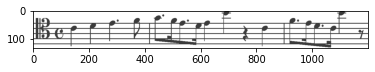

In [ ]:
# #Data loading

data_path = "/content/Aps360Project/Project_Data_Big"
#extract images and labels from dataset folder and put into arrays
images = []
label = []
counter = 0
for root, dirs, files in os.walk(data_path):
  if counter > 8:
    break
  counter+=1
  for file in files:
    filename = str(file)
    if (filename.endswith('.png') and not filename.startswith('._')):
      #print(str(root))
      filepath = str(root) + '/' + str(file)
      img = plt.imread(filepath)
      img_cropped = img[0:154, 0:1200]
      images.append(img_cropped)
    if (filename.endswith('.semantic') and not filename.startswith('._')):
      filepath = str(root) + '/' + str(file)
      f = open(filepath, 'r')
      contents = f.read()
      elements = contents.split("\t", 50)
      #print(elements)
      semantic = []
      for element in elements:
        #print(element)
        if element.startswith('note'):
          element = element[5:8]
          if element.endswith('_'):
            element = element[:-1]
          semantic.append(element)

      label.append(semantic)


#example image and label
plt.imshow(images[3]) 
print(label[3])


#call functions on label set to generate integer labels
int_label = []
noteDict = {}
for semantic in label:
  int_semantic = []
  for note in semantic:
    int_semantic.append(letter_to_int(note, noteDict))
  int_label.append(int_semantic)  



In [ ]:
# #Data loading

# data_path = '/content/Aps360Project/Project_Data_Big'
# save_path = '/content/Aps360Project/Data'
# #extract images and labels from dataset folder and put into arrays
# # images = []
# # label = []
# noteDict = {}
# counter = 0
# for root, dirs, files in os.walk(data_path):
#   if counter > 2048:
#     break
#   counter+=1
#   for file in files:
#     filename = str(file)
#     if (filename.endswith('.png') and not filename.startswith('._')):
#       #print(str(root))
#       filepath = str(root) + '/' + str(file)
#       img = plt.imread(filepath)
#       img_cropped = img[0:154, 0:1200]
#       #images.append(img_cropped)
#       torch.save(img_cropped, str(save_path) + '/Images/image' + str(counter)+'.pt')


#     if (filename.endswith('.semantic') and not filename.startswith('._')):
#       filepath = str(root) + '/' + str(file)
#       f = open(filepath, 'r')
#       contents = f.read()
#       elements = contents.split("\t", 50)
#       #print(elements)
#       semantic = []
#       for element in elements:
#         #print(element)
#         if element.startswith('note'):
#           element = element[5:8]
#           if element.endswith('_'):
#             element = element[:-1]
#           semantic.append(element)

#       #label.append(semantic)
#       torch.save(semantic, str(save_path) + '/Labels/label' + str(counter)+'.pt')
#       for semantic in label:
#         int_semantic = []
#         for note in semantic:
#           int_semantic.append(letter_to_int(note, noteDict))
  
#         torch.save(int_semantic, str(save_path) + '/IntLabels/int_label' + str(counter)+'.pt')




In [ ]:
# counter = 0
# for root, dirs, files in os.walk(str(save_path)+ '/Semantics/'):
#   for file in files:
#     counter +=1
# print(counter)
# counter = 0
# for root, dirs, files in os.walk(str(save_path)+ '/Images/'):
#   for file in files:
#     counter +=1
# print(counter)
# counter = 0
# for root, dirs, files in os.walk(str(save_path)+ '/IntSemantics/'):
#   for file in files:
#     counter +=1
# print(counter)

In [ ]:
#Create list of tensors (to be converted to a tensor)
image_tensors_list = [torch.from_numpy(item).float() for item in images]

In [ ]:
#Code to figure out padding for data (images)
# for i in range(10):
#   print(image_tensors_list[i].shape)
# print(image_tensors_list[0].shape[0])
# print(image_tensors_list[0].shape[1])
# print(image_tensors_list[0].shape[2])

max_along0 = 0
max_along1 = 0
for i in range(len(image_tensors_list)):
  if ( image_tensors_list[i].shape[0] > max_along0 ):
    max_along0 = image_tensors_list[i].shape[0]
  if ( image_tensors_list[i].shape[1] > max_along1 ):
    max_along1 = image_tensors_list[i].shape[1]
print(max_along0)
print(max_along1)

154
1200


In [ ]:
#Find max lenght of labels for padding
def FindMaxLength(lst): 
    maxList = max((x) for x in lst) 
    maxLength = max(len(x) for x in lst ) 
  
    return maxList, maxLength 
maxList, maxLength  = FindMaxLength(int_label)

print(maxLength)


18


In [ ]:
#padding list of labels with blank notes (0s)

for i in range(len(int_label)):
  int_label[i] += [0] * (maxLength - len( int_label[i]))

#padding list of tensors (data) with a bunch or zeros
target = torch.zeros(30, 35, 512)
source = torch.ones(30, 35, 49)

for i in range(len(image_tensors_list)):
  target = torch.zeros(max_along0, max_along1, 3)
  target[:image_tensors_list[i].shape[0], :image_tensors_list[i].shape[1], :] = image_tensors_list[i]
  image_tensors_list[i] = target
#convert image into a tensor
#create tensor of data


image_tensors_list_tensor = torch.stack(image_tensors_list)
print(image_tensors_list_tensor.shape)

torch.Size([8, 154, 1200, 3])


In [ ]:
print(image_tensors_list_tensor.permute(0,3,1,2).size())

torch.Size([8, 3, 154, 1200])


In [ ]:
image_tensors_list_tensor = image_tensors_list_tensor.permute(0,3,1,2)

In [ ]:



#split labels
training_labels = int_label[:108]
validation_labels = int_label[108:144]
testing_labels = int_label[144:]

#transform tensors to labels

training_labels_tensor = torch.FloatTensor(training_labels)
validation_labels_tensor = torch.FloatTensor(validation_labels)
testing_labels_tensor = torch.FloatTensor(testing_labels)

#split data (180 samples not 320)
# training_data = images[:108]
# validation_data = images[108:144]
# testing_data = images[144:]

#split tensor data
training_tensor= image_tensors_list_tensor[:108]
validation_tensor = image_tensors_list_tensor[108:144]
testing_tensor = image_tensors_list_tensor[144:]





In [ ]:
#Small loader for overfitting
small_labels = int_label[:5]
small_labels_tensor = torch.FloatTensor(small_labels)
small_tensor= image_tensors_list_tensor[:5]
small_dataset = TensorDataset(small_tensor,small_labels_tensor) # training dataset
small_loader = DataLoader(small_dataset,batch_size=5, shuffle=True) # create your dataloader

In [ ]:
print(training_labels_tensor.shape)

In [ ]:
print(image_tensors_list[0].shape)
print(len(image_tensors_list))

In [ ]:
print(len(int_label))
print(len(training_labels))
print(len(validation_labels))
print(len(testing_labels))

In [ ]:
batch_size = 32

In [ ]:
#"Final" datasets and dataloaders
training_dataset = TensorDataset(training_tensor,training_labels_tensor) # training dataset
training_loader = DataLoader(training_dataset,batch_size=batch_size, shuffle=True) # create your dataloader
validation_dataset = TensorDataset(validation_tensor,validation_labels_tensor) # training dataset
validation_loader = DataLoader(validation_dataset,batch_size=batch_size, shuffle=True) # create your dataloader
testing_dataset = TensorDataset(testing_tensor,testing_labels_tensor) # training dataset
testing_loader = DataLoader(testing_dataset,batch_size=batch_size, shuffle=True) # create your dataloader

In [ ]:
flat_sz, Hnew,Wnew,last_output_channel_sz = MozartF1Helper(max_along0,max_along1,20,conv_layers = 3,kernel_sizes = [5,5,5],max_pooled = [True,True,False])
print(flat_sz)
print(Hnew)
print(Wnew)

In [ ]:
#Baseline model training: MozartCNN
BaselineModel = MozartCNN(3,max_along0,max_along1,5,10, 20, 64,30,5)
train_acc_b0, val_acc_b0, train_loss_b0, val_loss_b0 = train(BaselineModel, training_loader,validation_loader,32, num_epochs=1000, lr = 0.001, update = True, plot = True, save = True)

In [ ]:
#Highest Training Accuracy on Epoch  910 TrAcc:  0.8089506172839506 ValAcc:  0.05092592592592592 TrLoss:  0.14224201440811157 ValLoss:  209.2037811279297
#As expected the baseline model does not allow for generalization 

In [ ]:
#Baseline model training: MozartCNN
BaselineModelOverfit = MozartCNN(3,max_along0,max_along1,5,10, 20, 64,30,5)
train_acc_b0, val_acc_b0, train_loss_b0, val_loss_b0 = train(BaselineModelOverfit, small_loader,small_loader,5, num_epochs=1000, lr = 0.001, update = True, plot = True, save = False)

##Data Loading

In [ ]:
#Data loading

# data_path = dpath + "Project_Data_Sorted"
data_path = "/content/Aps360Project/Project_Data_Big"
#extract images and labels from dataset folder and put into arrays
images = []
label = []
counter = 0
for root, dirs, files in os.walk(data_path):
  if counter > 2048:
    break
  for file in files:
    filename = str(file)
    if (filename.endswith('.png') and not filename.startswith('._')):
      #print(str(root))
      filepath = str(root) + '/' + str(file)
      img = plt.imread(filepath)
      img_cropped = img[0:154, 0:1200]
      images.append(img_cropped)
    if (filename.endswith('.semantic') and not filename.startswith('._')):
      filepath = str(root) + '/' + str(file)
      f = open(filepath, 'r')
      contents = f.read()
      elements = contents.split("\t", 50)
      #print(elements)
      semantic = []
      for element in elements:
        #print(element)
        if element.startswith('note'):
          element = element[5:8]
          if element.endswith('_'):
            element = element[:-1]
          semantic.append(element)

      label.append(semantic)
  counter += 1
print(counter)
#example image and label
# plt.imshow(images[3]) 
# print(label[3])

#convert labels to integer encoding

#helper functions

letters_to_numbers =  {
  'C':0,
  'D':2,
  'E':4,
  'F':5,
  'G':7,
  'A':9,
  'B':11
  }
accidentals_to_numbers = {
    'x':2,
    '#':1,
    '':0,
    'n':0,
    'b':-1,
    'bb':-2
}
def letter_to_int(noteId, noteDict):
  #Get octave
  octaveNum = int(noteId[-1])
  #Get letter name
  letterName = noteId[0]
  letterNum = letters_to_numbers[letterName]
  #Get accidental  
  accidentalName = noteId[1:-1]
  accidentalNum = accidentals_to_numbers[accidentalName]
  #Add together
  noteNum = (octaveNum+1)*12+letterNum+accidentalNum
  noteDict[noteNum] = noteId
  return noteNum

#call functions on label set to generate integer labels
int_label = []
noteDict = {}
for semantic in label:
  int_semantic = []
  for note in semantic:
    int_semantic.append(letter_to_int(note, noteDict))
  int_label.append(int_semantic)  



2049


In [ ]:
#Create list of tensors (to be converted to a tensor)
image_tensors_list = [torch.from_numpy(item).float() for item in images]

In [ ]:
# torch.save(label, '/content/label_list.pt')

In [ ]:
label = []

In [ ]:
#label = torch.load('/content/label_list.pt')
#print(label)

In [ ]:
# torch.save(image_tensors_list, '/content/image_tensors_list.pt')

In [ ]:
images = []
#image_tensors_list = []

In [ ]:
#image_tensors_list = torch.load('/content/image_tensors_list.pt')

In [ ]:
#Code to figure out padding for data (images)
# for i in range(10):
#   print(image_tensors_list[i].shape)
# print(image_tensors_list[0].shape[0])
# print(image_tensors_list[0].shape[1])
# print(image_tensors_list[0].shape[2])

max_along0 = 0
max_along1 = 0
for i in range(len(image_tensors_list)):
  if ( image_tensors_list[i].shape[0] > max_along0 ):
    max_along0 = image_tensors_list[i].shape[0]
  if ( image_tensors_list[i].shape[1] > max_along1 ):
    max_along1 = image_tensors_list[i].shape[1]
print(max_along0)
print(max_along1)

154
1200


In [ ]:
#Find max lenght of labels for padding
def FindMaxLength(lst): 
    maxList = max((x) for x in lst) 
    maxLength = max(len(x) for x in lst ) 
  
    return maxList, maxLength 
maxList, maxLength  = FindMaxLength(int_label)

print(maxLength)


47


In [ ]:
#padding list of labels with blank notes (0s)

for i in range(len(int_label)):
  int_label[i] += [0] * (maxLength - len( int_label[i]))

#padding list of tensors (data) with a bunch or zeros
target = torch.zeros(30, 35, 512)
source = torch.ones(30, 35, 49)

for i in range(len(image_tensors_list)):
  target = torch.zeros(max_along0, max_along1, 3)
  target[:image_tensors_list[i].shape[0], :image_tensors_list[i].shape[1], :] = image_tensors_list[i]
  image_tensors_list[i] = target
#convert image into a tensor
#create tensor of data


image_tensors_list_tensor = torch.stack(image_tensors_list)
print(image_tensors_list_tensor.shape)

torch.Size([2048, 154, 1200, 3])


In [ ]:
#image_tensors_list = []

In [ ]:
#torch.save(image_tensors_list_tensor, '/content/image_tensors_tensor.pt')

In [ ]:
print(image_tensors_list_tensor.permute(0,3,1,2).size())

torch.Size([2048, 3, 154, 1200])


In [ ]:
image_tensors_list_tensor = image_tensors_list_tensor.permute(0,3,1,2)

In [ ]:
#split labels
training_labels = int_label[:1638]
validation_labels = int_label[1638:1843]
testing_labels = int_label[1843:]

#transform tensors to labels

training_labels_tensor = torch.FloatTensor(training_labels)
validation_labels_tensor = torch.FloatTensor(validation_labels)
testing_labels_tensor = torch.FloatTensor(testing_labels)

#split data (180 samples not 320)
# training_data = images[:108]
# validation_data = images[108:144]
# testing_data = images[144:]

#split tensor data
training_tensor= image_tensors_list_tensor[:1638]
validation_tensor = image_tensors_list_tensor[1638:1843]
testing_tensor = image_tensors_list_tensor[1843:]

In [ ]:
print(training_labels_tensor.shape)

torch.Size([1638, 47])


In [ ]:
print(image_tensors_list[0].shape)
print(len(image_tensors_list))

torch.Size([154, 1200, 3])
2048


In [ ]:
print(len(int_label))
print(len(training_labels))
print(len(validation_labels))
print(len(testing_labels))

2048
1638
205
205


In [ ]:
max(map(max, int_label))

90

In [ ]:
image_tensors_list = []
#image_tensors_list_tensor = torch.Tensor(0)

In [ ]:
print(image_tensors_list)
#print(image_tensors_list_tensor)

[]


Need to drop last because inconsistent batch sizes don't work on our CRNN

In [ ]:
batch_size = 64
#"Final" datasets and dataloaders
training_dataset = TensorDataset(training_tensor,training_labels_tensor) # training dataset
training_loader = DataLoader(training_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader
validation_dataset = TensorDataset(validation_tensor,validation_labels_tensor) # training dataset
validation_loader = DataLoader(validation_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
batch_size = 64
testing_dataset = TensorDataset(testing_tensor,testing_labels_tensor) # training dataset
testing_loader = DataLoader(testing_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader

# **Our Primary Model**

This is a basic CRNN model; might be better to use pretrained model tho ahh

In [ ]:
# class MusicSheetCRNN(nn.Module):
#   def __init__(self, input_size, out_cn=5, kn_size=3, hid_units=60, rnn_hid_units=128, number_of_classes=91, batch_size=32):
#     super(MusicSheetCRNN, self).__init__()

#     self.name = "MusicSheetCRNN"
#     self.batch_size = batch_size
#     self.cnn_output_height = 37

#     # CNN layers
#     self.conv1 = nn.Conv2d(3, out_cn, kn_size) #in_channels, out_chanels, kernel_size
#     self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
#     self.conv2 = nn.Conv2d(out_cn, out_cn * 2, kn_size) #in_channels, out_chanels (doubled), kernel_size
#     #is input_size h or w?
#     #self.conv_output_size = self.calc_conv_output_size(input_size, kn_size, out_cn*2)
#     self.rnn_input_size = self.cnn_output_height * out_cn*2
#     # RNN layer
#     self.rnn_hid_units = rnn_hid_units
#     self.lstm = nn.LSTM(self.rnn_input_size, self.rnn_hid_units, batch_first=True)

#     # prediction: fully connected layers
#     self.fc1 = nn.Linear(self.rnn_hid_units, number_of_classes)
#     #self.fc2 = nn.Linear(hid_units, number_of_classes)

#   def calc_conv_output_size(self, input_size, kn, out_cn, num_layers=2):
#     """
#     0 padding, no stride, half pooling, initial image 224
#     """
#     # calculate output size of first convolution & pooling layer
#     s = ((input_size - kn) + 1) // 2
#     # calculate the output size of remaining convolution & pooling layers (num-1) times
#     for i in range(num_layers - 1):
#         s = ((s - kn) + 1) //2
#     return s * s * out_cn

#   def forward(self, x):
#     print(x.shape)
#     # CNN
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     #x = x.view(-1, 37 * 298 * 10)
#     print(x.shape)
#     x = x.permute(0, 3, 2, 1)
#     x = x.reshape(self.batch_size, -1, self.rnn_input_size)
#     print(x.shape)
#     # RNN
#     # Set an initial hidden state
#     h0 = torch.zeros(1, x.size(0), self.rnn_hid_units)
#     c0 = torch.zeros(1, x.size(0), self.rnn_hid_units)
#     # Forward propagate the LSTM
#     #print(x.shape)
#     out, _ = self.lstm(x, (h0, c0))
#     # Extract last layer of RNN (hyperparam)
#     #out = torch.cat([torch.max(out, dim=1)[0], 
#     #             torch.mean(out, dim=1)], dim=1)

#     # prediction
#     #x = F.relu(self.fc1(out))
#     #x = self.fc2(x)
#     #out = torch.stack([F.log_softmax(self.fc1(out[i]), dim=-1) for i in range(out.shape[0])])
#     #print("model output shape: ", out.shape)
#     out = torch.stack([self.fc1(out[i]) for i in range(out.shape[0])])
#     return out

##CURRENT

In [ ]:
def conv_outdims(input_w, input_h, kn_size, padding=0, stride=1):
  output_w = int((input_w - kn_size + 2*padding) / stride) + 1
  output_h = int((input_h - kn_size + 2*padding) / stride) + 1
  return output_w, output_h

In [ ]:
class MusicSheetCRNN(nn.Module):
  def __init__(self, input_w=1200, input_h=154, out_cn=5, kn_size=3, hid_units=60, rnn_hid_units=128, number_of_classes=92, batch_size=32):
    super(MusicSheetCRNN, self).__init__()

    self.name = "MusicSheetCRNN"
    self.batch_size = batch_size

    # CNN layers
    self.conv1 = nn.Conv2d(3, out_cn, kn_size) #in_channels, out_chanels, kernel_size
    self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
    self.conv2 = nn.Conv2d(out_cn, out_cn * 2, kn_size) #in_channels, out_chanels (doubled), kernel_size
    self.conv3 = nn.Conv2d(out_cn * 2, out_cn * 2 * 2, kn_size)
    self.conv4 = nn.Conv2d(out_cn * 2 * 2, out_cn * 2 * 2 * 2, kn_size)

    # compute conv output dimensions
    conv1_out_w, conv1_out_h = conv_outdims(input_w, input_h, kn_size)
    pool1_out_w, pool1_out_h = conv_outdims(conv1_out_w, conv1_out_h, kn_size=2, stride=2)
    conv2_out_w, conv2_out_h = conv_outdims(pool1_out_w, pool1_out_h, kn_size)
    pool2_out_w, pool2_out_h = conv_outdims(conv2_out_w, conv2_out_h, kn_size=2, stride=2)
    conv3_out_w, conv3_out_h = conv_outdims(pool2_out_w, pool2_out_h, kn_size)
    pool3_out_w, pool3_out_h = conv_outdims(conv3_out_w, conv3_out_h, kn_size=2, stride=2)
    conv4_out_w, conv4_out_h = conv_outdims(pool3_out_w, pool3_out_h, kn_size)
    
    self.cnn_output_width = conv4_out_w
    self.cnn_output_height = conv4_out_h

    self.rnn_input_size = self.cnn_output_height * out_cn * 2 * 2 * 2
    # RNN layer
    self.rnn_hid_units = rnn_hid_units
    self.lstm = nn.LSTM(self.rnn_input_size, self.rnn_hid_units, num_layers=3, bidirectional=True, batch_first=True)

    # prediction: fully connected layers
    self.fc1 = nn.Linear(self.rnn_hid_units * 2, number_of_classes)
    #self.fc2 = nn.Linear(hid_units, number_of_classes)

  def forward(self, x):
    # CNN
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = F.relu(self.conv4(x))
    print(x.shape)
    x = x.permute(0, 3, 2, 1)
    print(x.shape)
    x = x.reshape(self.batch_size, -1, self.rnn_input_size)
    print(x.shape)
    # RNN
    # Set an initial hidden state
    if use_cuda and torch.cuda.is_available():
      h0 = torch.zeros(6, x.size(0), self.rnn_hid_units).cuda()
      c0 = torch.zeros(6, x.size(0), self.rnn_hid_units).cuda()
    else:
      h0 = torch.zeros(6, x.size(0), self.rnn_hid_units)
      c0 = torch.zeros(6, x.size(0), self.rnn_hid_units)
    # Forward propagate the LSTM
    out, _ = self.lstm(x, (h0, c0))
    out = torch.stack([self.fc1(out[i]) for i in range(out.shape[0])])
    return out

Training old

In [ ]:
cnn_output_width = 298
blank_label = 90

In [ ]:
from itertools import groupby
def train_primary(model, training_loader, validation_loader, batch_size=32, num_epochs=1, lr=0.001, plot=False, save=False):
    #To use batch sizes we need to set them and prepare a DataLoader for each of the sets

    #training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batches, shuffle=True) #Shuffle
    #validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batches,  shuffle=True)
    
    criterion = nn.CTCLoss(blank_label, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    train_acc, val_acc, train_loss, val_loss  = [], [], [], []
    iterations = 0
    # training
    plot_epochs = 0

    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        for imgs, labels in iter(training_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
            optimizer.zero_grad()         # a clean up step for PyTorch  
            out = model(imgs)             # forward pass
            out = out.permute(1, 0, 2)
            out = F.log_softmax(out, dim=-1)
            out_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
            # print(out_lengths.shape)
            labels_lengths = torch.IntTensor([len(t) for t in labels])
            # print(labels_lengths.shape)
            # print(out.shape)
            # print(labels.shape)
            tr_loss = criterion(out, labels, out_lengths, labels_lengths)
            tr_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            iterations =iterations+1
            # from source below
            _, max_index = torch.max(out, dim=2)
            #print(out)
            #print(labels)
            #print("mi: ", max_index)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().numpy()) 
                prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
                if len(prediction) == len(labels[i]) and torch.all(prediction.eq(labels[i])):
                    train_correct += 1
                    #print(labels[i].shape)
                    #print(prediction)
                    #print(labels[i])
                #else:
                    #print("\n", raw_prediction)
                    #print("\n", prediction.shape)
                    #print(labels[i].shape)
                    #print(prediction)
                    #print(labels[i])
                train_total += 1
            
        for imgs, labels in iter(validation_loader):
            out = model(imgs)             # forward pass
            out = model(imgs)             # forward pass
            out = out.permute(1, 0, 2)
            out = F.log_softmax(out, dim=-1)
            out_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
            labels_lengths = torch.IntTensor([len(t) for t in labels])
            vl_loss = criterion(out, labels, out_lengths, labels_lengths)
            # from source below
            _, max_index = torch.max(out, dim=2)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().numpy())
                prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
                if len(prediction) == len(labels[i]) and torch.all(prediction.eq(labels[i])):
                    val_correct += 1
                val_total += 1

        plot_epochs = plot_epochs +1
        # save the current training information
        val_loss.append(float(vl_loss))
        train_loss.append(float(tr_loss))
        train_acc.append(train_correct / train_total) # compute training accuracy
        val_acc.append(val_correct / val_total)  # compute validation accuracy
        print("Epoch ", epoch+1, "TrAcc: ",train_acc[epoch],"ValAcc: ",val_acc[epoch],"TrLoss: ",train_loss[epoch], "ValLoss: ",val_loss[epoch], "\n")

        if save and (epoch + 1) % 10 == 0:
          # Save the current model (checkpoint) to a file
          model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, lr, epoch + 1)
          torch.save(model.state_dict(), model_path)

    # plotting
    
    plot_epochs_l = np.arange(1, plot_epochs + 1)
    if (plot):

      print("Epochs: {0}, Iterations: {1}, Batch Size: {2}, Learning Rate: {3}".format(plot_epochs, iterations, batch_size, lr))
      plt.title("Training Curve; Accuracy")
      plt.plot(plot_epochs_l, train_acc, label="Train")
      plt.plot(plot_epochs_l, val_acc, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()  
      plt.title("Training Curve; Loss")
      plt.plot(plot_epochs_l, train_loss, label="Train")
      plt.plot(plot_epochs_l, val_loss, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))

    print("Final Epochs: {}".format(plot_epochs))
    print("Final Iterations: {}".format(iterations))

    return


```
# from https://medium.com/swlh/multi-digit-sequence-recognition-with-crnn-and-ctc-loss-using-pytorch-framework-269a7aca2a6
    for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    train_acc.append(train_correct / train_total)
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)
```

##Training Code

need to check that dimensions are fine

In [ ]:
model_pri_test = MusicSheetCRNN(batch_size=64).cuda()
for imgs, labels in training_loader:  
    imgs = imgs.cuda()
    labels = labels.cuda()
    print(imgs.shape)
    out = model_pri_test(imgs)
    print(out.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 154, 1200])
torch.Size([64, 40, 15, 146])
torch.Size([64, 146, 15, 40])
torch.Size([64, 146, 600])
torch.Size([64, 146, 92])
torch.Size([64, 47])


In [ ]:
blank_label = 91

In [ ]:
def inject_note_breaks(labels, note_break=0):
  '''
  labels: list of list of integers
  '''
  result_list = []
  for i in range(len(labels)):
    result = []
    for j in range(len(labels[i])):
      result.append(labels[i][j].numpy())
      result.append(note_break)
    result_list.append(result)
  
  label_with_breaks = torch.FloatTensor(np.array(result_list))
  return label_with_breaks

In [ ]:
for imgs, labels in iter(training_loader):
  print(labels[0])
  print(inject_note_breaks(labels)[0])
  break

tensor([62., 64., 66., 67., 66., 64., 66., 67., 69., 67.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.])
tensor([62.,  0., 64.,  0., 66.,  0., 67.,  0., 66.,  0., 64.,  0., 66.,  0.,
        67.,  0., 69.,  0., 67.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [ ]:
from itertools import groupby

In [ ]:
def train_primary(model, training_loader, validation_loader, batch_size=32, num_epochs=1, lr=0.001, 
                  plot=False, save=False, save_final=False, print_res=True, model_final_name="model1"):
    #To use batch sizes we need to set them and prepare a DataLoader for each of the sets

    #training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batches, shuffle=True) #Shuffle
    #validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batches,  shuffle=True)
    
    criterion = nn.CTCLoss(blank_label, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    train_acc, val_acc, train_loss, val_loss  = [], [], [], []
    iterations = 0
    # training
    plot_epochs = 0

    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        for imgs, labels in iter(training_loader):
            #labels = inject_note_breaks(labels)
            out_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
            labels_lengths = torch.IntTensor([len(t) for t in labels])

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              out_lengths = out_lengths.cuda()
              labels_lengths = labels_lengths.cuda()
            #############################################
            
            optimizer.zero_grad()         # a clean up step for PyTorch  
            out = model(imgs)             # forward pass
            out = out.permute(1, 0, 2)
            out = F.log_softmax(out, dim=-1)
            tr_loss = criterion(out, labels, out_lengths, labels_lengths)
            tr_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            iterations =iterations+1
            # from source below
            _, max_index = torch.max(out, dim=2)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().cpu().numpy())
                prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label and c != 0])
                if use_cuda and torch.cuda.is_available():
                  prediction = prediction.cuda()
                curr_label = labels[i]
                correct_label = curr_label[curr_label.nonzero().squeeze()] # remove zero padding
                #if len(prediction) == len(correct_label) and torch.all(prediction.eq(correct_label)):
                #    train_correct += 1
                #train_total += 1
                correct_notes = 0
                if len(prediction) < len(correct_label):
                  num_notes = len(prediction)
                else:
                  num_notes = len(correct_label)
                for j in range(num_notes):
                  if prediction[j] == correct_label[j]:
                    correct_notes += 1
                train_correct += correct_notes / len(correct_label)
                train_total += 1
            
        for imgs, labels in iter(validation_loader):
            out_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
            labels_lengths = torch.IntTensor([len(t) for t in labels])
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              out_lengths = out_lengths.cuda()
              labels_lengths = labels_lengths.cuda()
            #############################################
            out = model(imgs)             # forward pass
            out = out.permute(1, 0, 2)
            out = F.log_softmax(out, dim=-1)
            vl_loss = criterion(out, labels, out_lengths, labels_lengths)
            # from source below
            _, max_index = torch.max(out, dim=2)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().cpu().numpy())
                prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label and c != 0])
                if use_cuda and torch.cuda.is_available():
                  prediction = prediction.cuda()
                curr_label = labels[i]
                correct_label = curr_label[curr_label.nonzero().squeeze()] # remove zero padding
                #if len(prediction) == len(correct_label) and torch.all(prediction.eq(correct_label)):
                #    val_correct += 1
                #val_total += 1
                correct_notes = 0
                if len(prediction) < len(correct_label):
                  num_notes = len(prediction)
                else:
                  num_notes = len(correct_label)
                for j in range(num_notes):
                  if prediction[j] == correct_label[j]:
                    correct_notes += 1
                val_correct += correct_notes / len(correct_label)
                val_total += 1

        plot_epochs = plot_epochs +1
        # save the current training information
        val_loss.append(float(vl_loss))
        train_loss.append(float(tr_loss))
        train_acc.append(train_correct / train_total) # compute training accuracy
        val_acc.append(val_correct / val_total)  # compute validation accuracy
        if print_res:
          print("Epoch ", epoch+1, "TrAcc: ",train_acc[epoch],"ValAcc: ",val_acc[epoch],"TrLoss: ",train_loss[epoch], "ValLoss: ",val_loss[epoch], "\n")

        if save and (epoch + 1) % 20 == 0:
          # Save the current model (checkpoint) to a file
          model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, lr, epoch + 1)
          torch.save(model.state_dict(), model_path)
    
    # save final model
    if save_final:
      torch.save(model.state_dict(), model_final_name)
    # plotting
    
    plot_epochs_l = np.arange(1, plot_epochs + 1)
    if (plot):

      print("Epochs: {0}, Iterations: {1}, Batch Size: {2}, Learning Rate: {3}".format(plot_epochs, iterations, batch_size, lr))
      plt.title("Training Curve; Accuracy")
      plt.plot(plot_epochs_l, train_acc, label="Train")
      plt.plot(plot_epochs_l, val_acc, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()  
      plt.title("Training Curve; Loss")
      plt.plot(plot_epochs_l, train_loss, label="Train")
      plt.plot(plot_epochs_l, val_loss, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))

    print("Final Epochs: {}".format(plot_epochs))
    print("Final Iterations: {}".format(iterations))

    return


```
# from https://medium.com/swlh/multi-digit-sequence-recognition-with-crnn-and-ctc-loss-using-pytorch-framework-269a7aca2a6
    for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    train_acc.append(train_correct / train_total)
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)
```

##Analyzing outputs over small dataset

In [ ]:
#Small loader for overfitting
psmall_labels = int_label[:2]
psmall_labels_tensor = torch.FloatTensor(psmall_labels)
psmall_tensor= image_tensors_list_tensor[:2]
psmall_dataset = TensorDataset(psmall_tensor, psmall_labels_tensor) # training dataset
psmall_loader = DataLoader(psmall_dataset, batch_size=1, shuffle=True) # create your dataloader

In [ ]:
use_cuda = True
model_pri_s = MusicSheetCRNN(number_of_classes=92, batch_size=1)

if use_cuda and torch.cuda.is_available():
  model_pri_s.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


torch.Size([1, 40, 15, 146])
torch.Size([1, 146, 15, 40])
torch.Size([1, 292, 300])
torch.Size([1, 40, 15, 146])
torch.Size([1, 146, 15, 40])
torch.Size([1, 292, 300])
Epoch  1 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  11.389030456542969 ValLoss:  11.083904266357422 

Epochs: 1, Iterations: 1, Batch Size: 1, Learning Rate: 0.001


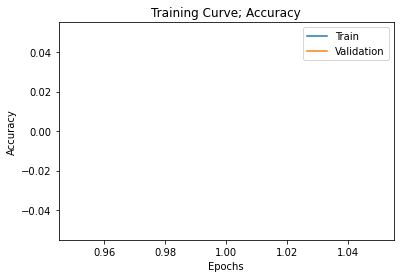

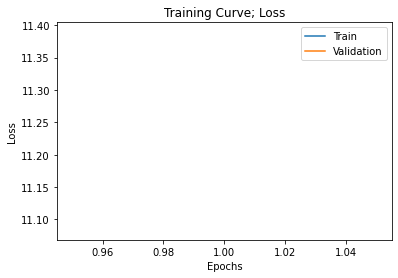

Final Training Accuracy: 0.0
Final Validation Accuracy: 0.0
Final Training Loss: 11.389030456542969
Final Validation Loss: 11.083904266357422
Final Epochs: 1
Final Iterations: 1


In [ ]:
train_primary(model_pri_s, psmall_loader, psmall_loader, 1, num_epochs=1, lr = 0.001, plot=True, save=False)

Have the model learn the breaks? Inject blank character between every note so [55, 55, 55] becomes [55, 90, 55, 90, 55, 90]?

##Regular Dataset

In [ ]:
use_cuda = True
model_pri = MusicSheetCRNN(number_of_classes=92, batch_size=64)

if use_cuda and torch.cuda.is_available():
  model_pri.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


Epoch  1 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0412285327911377 ValLoss:  1.0979083776474 

Epoch  2 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0184451341629028 ValLoss:  1.0998151302337646 

Epoch  3 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.006742238998413 ValLoss:  1.07181978225708 

Epoch  4 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  0.9798440933227539 ValLoss:  1.1080273389816284 

Epoch  5 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.040299654006958 ValLoss:  1.0915113687515259 

Epoch  6 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0845208168029785 ValLoss:  1.0374120473861694 

Epoch  7 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0525785684585571 ValLoss:  1.046262264251709 

Epoch  8 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.04464852809906 ValLoss:  0.9965578317642212 

Epoch  9 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0111713409423828 ValLoss:  1.077646255493164 

Epoch  10 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  0.9787642955780029 ValLoss:  1.0694421529769897 

Epoch  11 TrAcc:  0.0 ValAcc:  0.0 TrLoss:  1.0234055519104004 ValLoss:  1.04993

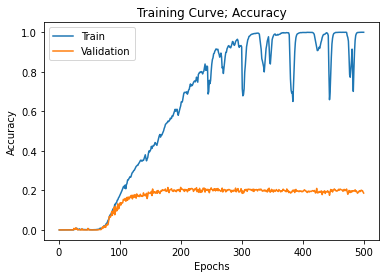

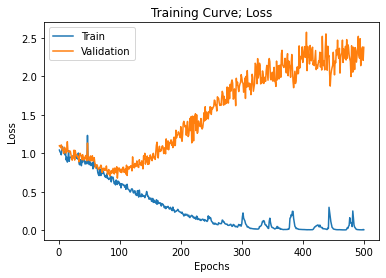

Final Training Accuracy: 0.9996074054621849
Final Validation Accuracy: 0.18638647908420503
Final Training Loss: 0.005564004648476839
Final Validation Loss: 2.37614369392395
Final Epochs: 500
Final Iterations: 12500


In [ ]:
train_primary(model_pri, training_loader, validation_loader, 64, num_epochs=500, lr = 0.001, plot=True, save=True)

In [ ]:
model = model_pri
criterion = nn.CTCLoss(blank_label, zero_infinity=True)
for imgs, labels in training_loader:
  #labels = inject_note_breaks(labels)
  out_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
  labels_lengths = torch.IntTensor([len(t) for t in labels])

  #############################################
  #To Enable GPU Usage
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
    out_lengths = out_lengths.cuda()
    labels_lengths = labels_lengths.cuda()
  #############################################
  out = model(imgs)
  out = out.permute(1, 0, 2)
  out = F.log_softmax(out, dim=-1)
  print(labels_lengths.shape)
  print(criterion(out, labels, out_lengths, labels_lengths))
  #print(out)
  #print(labels)
  _, max_index = torch.max(out, dim=2)
  #print(max_index)
  total_correct_notes = 0
  for i in range(1):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    print(raw_prediction)
    prediction = torch.FloatTensor([c for c, _ in groupby(raw_prediction) if c != blank_label and c != 0])
    if use_cuda and torch.cuda.is_available():
      prediction = prediction.cuda()
    print(prediction)
    curr_label = labels[i]
    correct_label = curr_label[curr_label.nonzero().squeeze()]
    print(correct_label)
    correct_notes = 0
    if len(prediction) < len(correct_label):
      num_notes = len(prediction)
    else:
      num_notes = len(correct_label)
    for j in range(num_notes):
      if prediction[j] == correct_label[j]:
        correct_notes += 1
    total_correct_notes += len(correct_label)
    if len(prediction) == len(correct_label) and torch.all(prediction.eq(correct_label)):
      print("correct")
    else:
      print(len(prediction))
      print(len(correct_label))
  print(correct_notes / total_correct_notes)
  break

torch.Size([64])
tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>)
[84, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 79, 91, 79, 91, 77, 91, 76, 91, 81, 91, 77, 91, 91, 91, 74, 91, 74, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 76, 91, 77, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0, 91, 0]
tensor([84., 79., 79., 77., 76., 81., 77., 74., 74., 76., 77.],
       device='cuda:0')
tensor([84., 79., 79., 77., 76., 81., 77., 74., 74., 76., 77.],
       device='cuda:0')
correct
1.0


# Transfer Learning Model


In [ ]:
# download vgg model & strip the last FC layer away & freeze parameters
resnet34 = torchvision.models.resnet34(pretrained=True)
resnet34 = torch.nn.Sequential(*(list(resnet34.children())[:-2]))
for param in resnet34.parameters():
    param.requires_grad = False
print(resnet34)



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Co

In [ ]:
vgg11 = torchvision.models.vgg11_bn(pretrained=True)
# vgg19 = vgg19.features

vgg11 = torch.nn.Sequential(*(list(vgg11.features.children())[:-1]))
for param in vgg11.parameters():
    param.requires_grad = False
print(vgg11)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## Computing, Saving, and Loading Features

Mount Google Drive and define a path to save features
(replace with your own path, I think this is specific to Nancy's drive)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = "/content/gdrive/.shortcut-targets-by-id/1fEMnaweRPt_MZzfehmDCWykeBCjFet9r/APS360 Project/Resnet_Features"

Mounted at /content/gdrive


In [ ]:
for img, label in psmall_loader:
  print(img.shape)
  print(label.shape)

torch.Size([1, 3, 154, 1200])
torch.Size([1, 47])


In [ ]:
# import os
# # img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

# file_dir = "/content/Aps360Project/Resnet_Features"

# def compute_resnet_features(model_features, data_loader, name):
#   feature_list = []
#   feature_labels = []
#   # i = 0
#   # comp_features = torch.tensor(())
#   for imgs, labels in iter(data_loader):
#     features.append(model_features(imgs))
#     feature_labels.append(labels)
#     # dir = file_dir + '/' + name + '/' + str(labels.numpy())
#     # if not os.path.isdir(dir):
#       # os.mkdir(dir)
#     # torch.save(features.squeeze(0), dir + '/' + str(i) + '.tensor')
#     i += 1
#   feature_tensor = torch.stack(feature_list)
#   label_tensor = torch.FloatTensor(feature_labels)


In [ ]:
import os
# compute features if they don't exist on disk
# if recompute is true, the dataloader is recreated regardless
def compute_resnet_features(model_features, data_loader, name, batch_size=32, recompute=False):
  fpath = path + "/" + name
  tensorname = fpath + "/" + name + "11" + "_tensors.ph"
  labelname = fpath + "/" + name + "11" + "_labels.ph"
  filename = fpath + "/" + name + "11" + "_" + str(batch_size) + '_floader.pth'
  if os.path.exists(filename) and not recompute:
    print("floader already exists! reloading")
    return torch.load(filename)

  t = None
  l = None
  req_t, req_l = True, True
  if os.path.exists(tensorname) and not recompute:
    print("tensor already exists! reloading")
    t = torch.load(tensorname)
    print(t.shape)
    req_t = False
  if os.path.exists(labelname) and not recompute:
    print("label already exists! reloading")
    l = torch.load(labelname)
    req_l = False
  if req_t or req_l:
    tensors = []
    labels = []
    for img, label in iter(data_loader):
      if req_t:
        features = model_features(img)
        tensors.append(features.squeeze())
      if req_l:
        labels.append(label.squeeze())
    if req_t:
      t = torch.stack(tensors)
    if req_l:
      l = torch.stack(labels)
    # torch.save(t, tensorname)
    # torch.save(l, labelname)

  dataset = TensorDataset(t, l) # training dataset
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader
  # torch.save(loader, filename)
  return loader


In [ ]:
# # check reloading
# temp = torch.load(path + "/small_floader.pth")
# for img, label in temp:
#     for i, l in small_floader:
#       assert i.equal(img)
#       assert l.equal(label)
#       break

In [ ]:
use_cuda = True
batch_size = 1
#"Final" datasets and dataloaders
# training_loader = DataLoader(training_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader
# validation_loader = DataLoader(validation_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader
testing_loader = DataLoader(testing_dataset,batch_size=batch_size, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
small_floader = compute_resnet_features(vgg11, psmall_loader, "vgg_small", batch_size=1)

floader already exists! reloading


In [ ]:
batch_size = 32
# training_floader = compute_resnet_features(vgg11, training_loader, "vgg_training", batch_size=batch_size)
# validation_floader = compute_resnet_features(vgg11, validation_loader, "vgg_validation", batch_size=batch_size)
testing_floader = compute_resnet_features(vgg11, testing_loader, "testing", batch_size=batch_size)

In [ ]:
print(len(testing_floader))

6


In [ ]:
# small_floader = compute_resnet_features(resnet34, psmall_loader, "small")
# compute_resnet_features(resnet34, train_loader, " training")
# compute_resnet_features(resnet34, val_loader, "validation")
# compute_resnet_features(resnet34, test_loader, "testing")

In [ ]:
# # load from dataset
# def load_feature_data(batch_size=32):
#   train_tensors = torchvision.datasets.DatasetFolder(file_dir + "/training", loader=torch.load, extensions=('.tensor'))
#   train_floader = torch.utils.data.DataLoader(train_tensors, batch_size=batch_size, shuffle=True, drop_last=False)
#   val_tensors = torchvision.datasets.DatasetFolder(file_dir + "/validation", loader=torch.load, extensions=('.tensor'))
#   val_floader = torch.utils.data.DataLoader(val_tensors, batch_size=batch_size, shuffle=True, drop_last=False)
#   test_tensors = torchvision.datasets.DatasetFolder(file_dir + "/testing", loader=torch.load, extensions=('.tensor'))
#   test_floader = torch.utils.data.DataLoader(test_tensors, batch_size=batch_size, shuffle=True, drop_last=False)
#   return train_floader, val_floader, test_floader

In [ ]:
# batch_size = 32
# train_floader, val_floader, test_floader = load_feature_data(batch_size)

## RNN model

Model hyperparameters are:
- number of LSTM layers (paper uses 2)
- dropout
- bidirectional or not

In [ ]:
class MusicSheetTLRNN(nn.Module):
  def __init__(self, dropout=0, bidirectional=False, num_layers=1,
               hid_units=60, rnn_hid_units=128, number_of_classes=92, batch_size=32):
    super(MusicSheetTLRNN, self).__init__()

    self.name = "MusicSheetTLRNN"
    self.batch_size = batch_size
    self.cnn_output_height = 37
    self.cnn_output_width = 190
    self.hc_size = num_layers * 2 if bidirectional else num_layers

    # TODO
    self.rnn_input_size = 512

    # RNN layer
    self.rnn_hid_units = rnn_hid_units
    self.lstm = nn.LSTM(self.rnn_input_size, self.rnn_hid_units, batch_first=True, 
                        num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
    # self.lstm2 = nn.LSTM(self.rnn_hid_units, self.rnn_hid_units, batch_first=True)

    # dropout
    # self.dropout = nn.Dropout(0.4)

    factor = 2 if bidirectional else 1
    # prediction: fully connected layers
    self.fc1 = nn.Linear(self.rnn_hid_units * factor, number_of_classes)
    #self.fc2 = nn.Linear(hid_units, number_of_classes)

  def forward(self, x):
    # x = self.feature(x)
    # print(x.shape)

    x = x.permute(0, 3, 2, 1)
    x = x.reshape(self.batch_size, -1, self.rnn_input_size)

    # RNN
    # Set an initial hidden state
    if use_cuda and torch.cuda.is_available():
      h0 = torch.zeros(self.hc_size, x.size(0), self.rnn_hid_units).cuda()
      c0 = torch.zeros(self.hc_size, x.size(0), self.rnn_hid_units).cuda()
    else:
      h0 = torch.zeros(self.hc_size, x.size(0), self.rnn_hid_units)
      c0 = torch.zeros(self.hc_size, x.size(0), self.rnn_hid_units)
    # Forward propagate the LSTM
    out, _ = self.lstm(x, (h0, c0))
    # print(out.shape)

    # Extract last layer of RNN (hyperparam)    
    # prediction
    out = torch.stack([self.fc1(out[i]) for i in range(out.shape[0])])
    return out

## Training

In [ ]:
def TL_train(model, train_loader, valid_loader, batch_size=32, num_epochs=1, lr=0.001, 
             plot=False, save=False, save_final=False, print_res=False, model_final_name="model1"):
   if use_cuda and torch.cuda.is_available():
     model.cuda()
   train_primary(model, train_loader, valid_loader, batch_size=batch_size, num_epochs=num_epochs, lr=lr, 
                 plot=plot, save=save, save_final=save_final, print_res=print_res, model_final_name=path + "/" + model_final_name)

### Overfitting small dataset

In [ ]:
model = MusicSheetTLRNN(batch_size=1, num_layers=2, bidirectional=True)

Epochs: 500, Iterations: 1000, Batch Size: 1, Learning Rate: 0.001


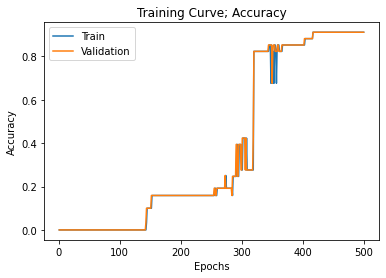

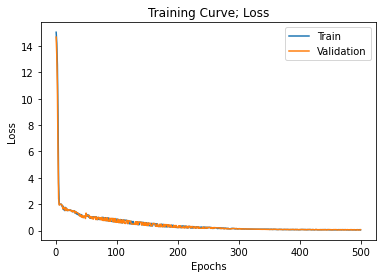

Final Training Accuracy: 0.9117647058823529
Final Validation Accuracy: 0.9117647058823529
Final Training Loss: 0.05437702685594559
Final Validation Loss: 0.07088257372379303
Final Epochs: 500
Final Iterations: 1000


In [ ]:
TL_train(model, small_floader, small_floader, num_epochs=500, batch_size=1, plot=True)

### test 1: single layer

In [ ]:
# batch size 32
model = MusicSheetTLRNN(feature_model=resnet34, batch_size=32)
TL_train(model, training_floader, validation_floader, num_epochs=1000, plot=True, save_final=True, model_final_name="model1")

Epochs: 300, Iterations: 7500, Batch Size: 64, Learning Rate: 0.001


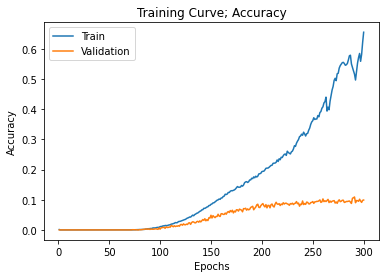

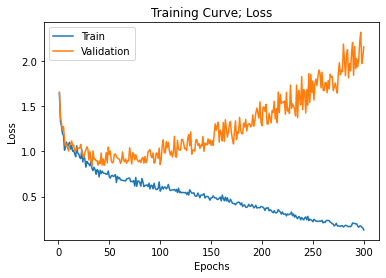

Final Training Accuracy: 0.6548169656925231
Final Validation Accuracy: 0.09904022277772422
Final Training Loss: 0.13188639283180237
Final Validation Loss: 2.1550073623657227
Final Epochs: 300
Final Iterations: 7500


In [ ]:
# batch size 64
model = MusicSheetTLRNN(feature_model=resnet34, batch_size=64)
TL_train(model, training_floader, validation_floader, batch_size=64, num_epochs=300, plot=True, save_final=True, model_final_name="model2")

Epochs: 300, Iterations: 7500, Batch Size: 64, Learning Rate: 0.001


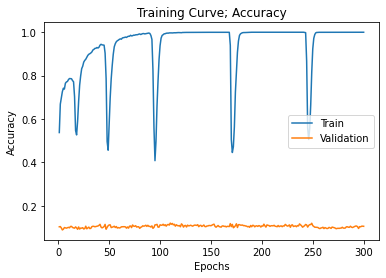

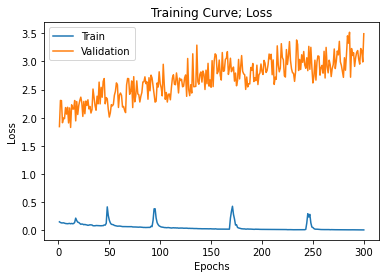

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.1051051714697772
Final Training Loss: 0.006622948218137026
Final Validation Loss: 3.4908924102783203
Final Epochs: 300
Final Iterations: 7500


In [ ]:
# continued from batch size 64
TL_train(model, training_floader, validation_floader, batch_size=64, num_epochs=300, plot=True, save_final=True, model_final_name="model2-1")

### Test 2: double layer

Epochs: 300, Iterations: 7500, Batch Size: 64, Learning Rate: 0.001


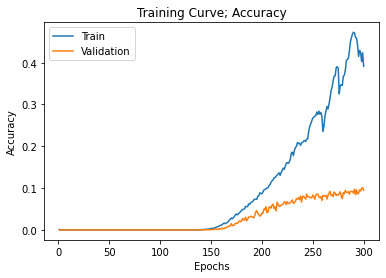

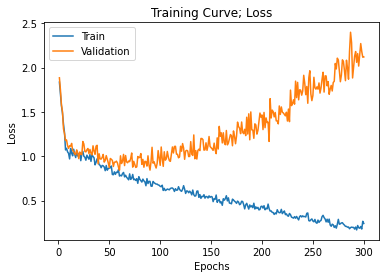

Final Training Accuracy: 0.3912812285600773
Final Validation Accuracy: 0.09521483243680869
Final Training Loss: 0.24121442437171936
Final Validation Loss: 2.118797540664673
Final Epochs: 300
Final Iterations: 7500


In [ ]:
model = MusicSheetTLRNN(feature_model=resnet34, batch_size=64)
TL_train(model, training_floader, validation_floader, batch_size=64, num_epochs=300, plot=True, save_final=True, model_final_name="model3")

Epochs: 300, Iterations: 7500, Batch Size: 64, Learning Rate: 0.001


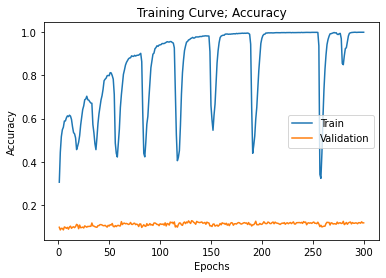

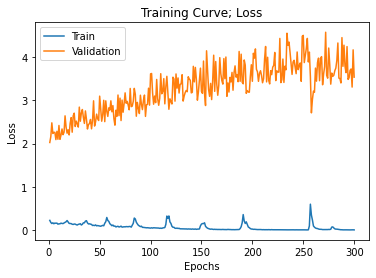

Final Training Accuracy: 0.9999375
Final Validation Accuracy: 0.1165103603115863
Final Training Loss: 0.003907646052539349
Final Validation Loss: 3.5383448600769043
Final Epochs: 300
Final Iterations: 7500


In [ ]:
TL_train(model, training_floader, validation_floader, batch_size=64, num_epochs=300, plot=True, save_final=True, model_final_name="model3")

### Test 3: with droput

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


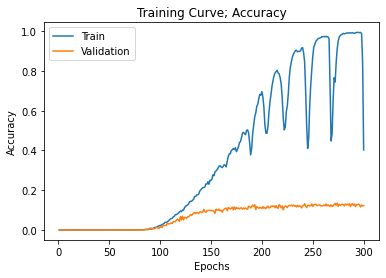

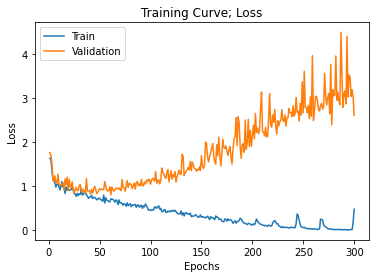

Final Training Accuracy: 0.4026941060696098
Final Validation Accuracy: 0.12215992365798327
Final Training Loss: 0.4770011007785797
Final Validation Loss: 2.6033055782318115
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, plot=True, save_final=True, model_final_name="model4")

Test 4: Bidirectional

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


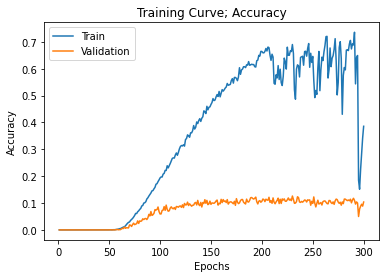

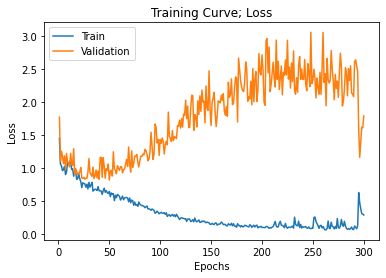

Final Training Accuracy: 0.385817891568242
Final Validation Accuracy: 0.10379793498291395
Final Training Loss: 0.29196280241012573
Final Validation Loss: 1.787412166595459
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=2, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="model5")

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


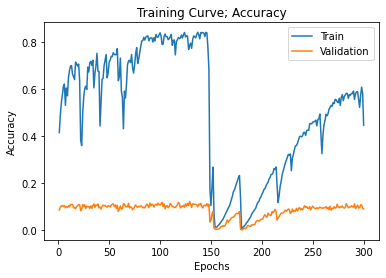

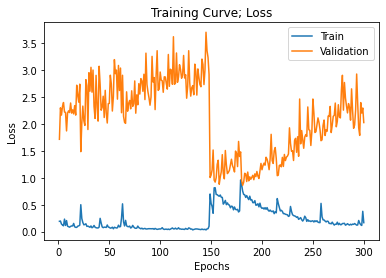

Final Training Accuracy: 0.44679205015356044
Final Validation Accuracy: 0.09062291810249816
Final Training Loss: 0.16673624515533447
Final Validation Loss: 2.0234899520874023
Final Epochs: 300
Final Iterations: 15300


In [ ]:
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="model5")

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


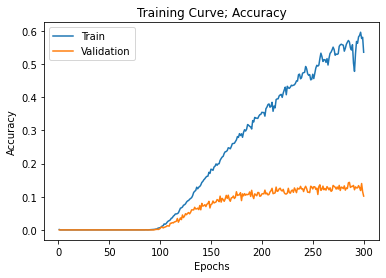

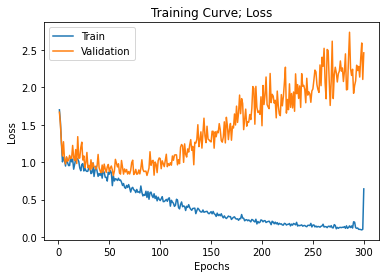

Final Training Accuracy: 0.5355136500000014
Final Validation Accuracy: 0.1019744329512467
Final Training Loss: 0.6431478261947632
Final Validation Loss: 2.462266445159912
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=3, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="model6")

## With more data

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


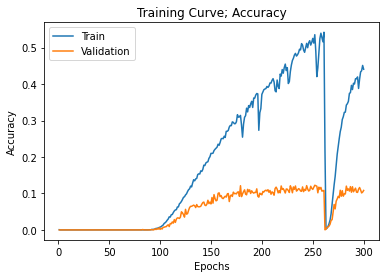

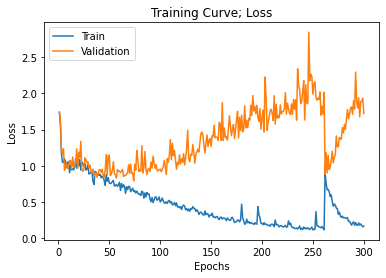

Final Training Accuracy: 0.44077018542472884
Final Validation Accuracy: 0.1082799737957628
Final Training Loss: 0.16678187251091003
Final Validation Loss: 1.7218940258026123
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=3, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="model6")

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


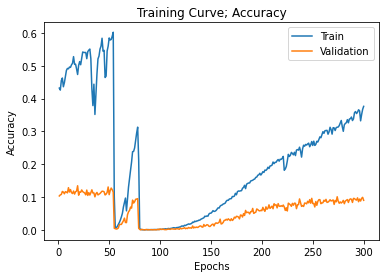

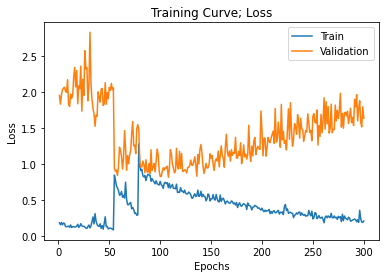

Final Training Accuracy: 0.3762479335059759
Final Validation Accuracy: 0.09014320047526847
Final Training Loss: 0.21087411046028137
Final Validation Loss: 1.6372551918029785
Final Epochs: 300
Final Iterations: 15300


In [ ]:
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="model6")

### VGG

In [ ]:
cd gdrive/.shortcut-targets-by-id/1fEMnaweRPt_MZzfehmDCWykeBCjFet9r/APS360 Project/Resnet_Features/

/content/gdrive/.shortcut-targets-by-id/1fEMnaweRPt_MZzfehmDCWykeBCjFet9r/APS360 Project/Resnet_Features


Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.001


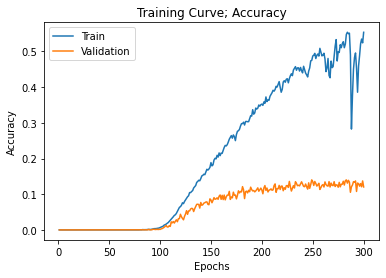

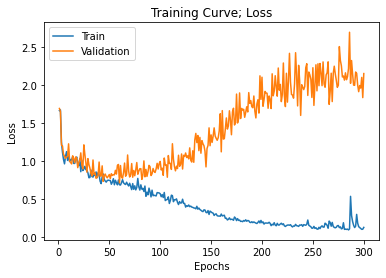

Final Training Accuracy: 0.5534451198790191
Final Validation Accuracy: 0.12032996311323325
Final Training Loss: 0.1295768767595291
Final Validation Loss: 2.150357484817505
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=3, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, 
         plot=True, save_final=True, model_final_name="vgg_model1")

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.01


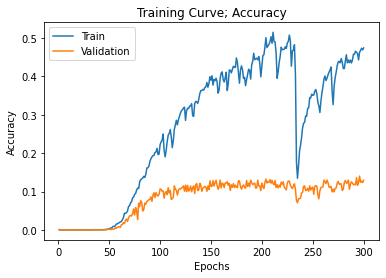

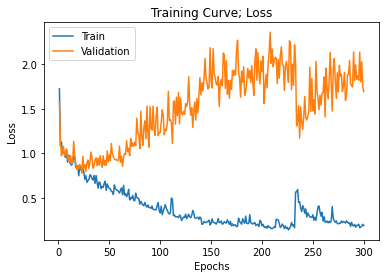

Final Training Accuracy: 0.47425193161792106
Final Validation Accuracy: 0.129347608570722
Final Training Loss: 0.19309109449386597
Final Validation Loss: 1.6948490142822266
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=2, dropout=0.4)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, lr=0.01,
         plot=True, save_final=True, model_final_name="vgg_model2")

Epochs: 300, Iterations: 15300, Batch Size: 32, Learning Rate: 0.01


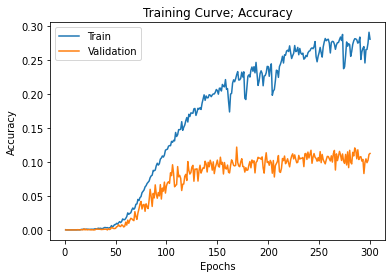

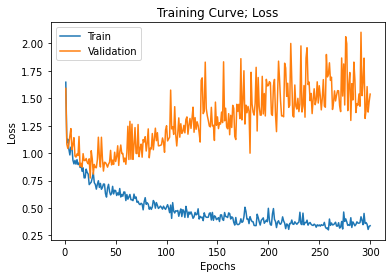

Final Training Accuracy: 0.2801986305155194
Final Validation Accuracy: 0.1123081223647575
Final Training Loss: 0.33850347995758057
Final Validation Loss: 1.5375244617462158
Final Epochs: 300
Final Iterations: 15300


In [ ]:
model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=2, dropout=0.55, rnn_hid_units=40, hid_units=40)
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=300, lr=0.01,
         plot=True, save_final=True, model_final_name="vgg_model3")

Epochs: 100, Iterations: 5100, Batch Size: 32, Learning Rate: 0.01


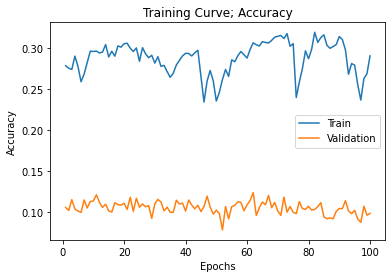

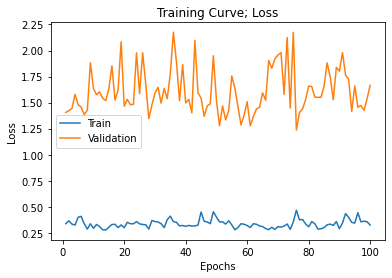

Final Training Accuracy: 0.29038876663950663
Final Validation Accuracy: 0.09842858929614585
Final Training Loss: 0.3247224688529968
Final Validation Loss: 1.6649399995803833
Final Epochs: 100
Final Iterations: 5100


In [ ]:
TL_train(model, training_floader, validation_floader, batch_size=32, num_epochs=100, lr=0.01,
         plot=True, save_final=True, model_final_name="vgg_model3-1")

## Testing

### Testing Accuracy

In [ ]:
def compute_accuracy(model, data_loader, batch_size=32):
  val_correct = 0
  val_total = 0
  for imgs, labels in iter(data_loader):
    out_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
    labels_lengths = torch.IntTensor([len(t) for t in labels])
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
      out_lengths = out_lengths.cuda()
      labels_lengths = labels_lengths.cuda()
    #############################################
    out = model(imgs)             # forward pass
    out = out.permute(1, 0, 2)
    out = F.log_softmax(out, dim=-1)
    # from source below
    _, max_index = torch.max(out, dim=2)
    for i in range(batch_size):
      raw_prediction = list(max_index[:, i].detach().cpu().numpy())
      prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label and c != 0])
      if use_cuda and torch.cuda.is_available():
        prediction = prediction.cuda()
      curr_label = labels[i]
      correct_label = curr_label[curr_label.nonzero().squeeze()] # remove zero padding
      correct_notes = 0
      if len(prediction) < len(correct_label):
        num_notes = len(prediction)
      else:
        num_notes = len(correct_label)
      for j in range(num_notes):
        if prediction[j] == correct_label[j]:
          correct_notes += 1
      val_correct += correct_notes / len(correct_label)
      val_total += 1
  
  return val_correct / val_total

### Best Model


In [ ]:
best_model = MusicSheetTLRNN(batch_size=32, bidirectional=True, num_layers=2, dropout=0.4)
state = torch.load(path + "/vgg_model2")
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
  best_model.cuda()

In [ ]:
test_acc = compute_accuracy(best_model, testing_floader)

In [ ]:
print("Final testing accuracy was ", test_acc)

Final testing accuracy was  0.11583677425820414


### Qualitative

In [ ]:
  # obtaining and processing image
  img = plt.imread('/content/someoneyouloved.png')
  img_cropped = img[0:154, 0:1200]
  plt.imshow(img_cropped)

  # feeding image to model
  out = best_model(torch.FloatTensor(img_cropped).permute(2, 1, 0).unsqueeze(0).cuda())
  out = out.permute(1, 0, 2)
  out = F.log_softmax(out, dim=-1)

  # decoding the output 
  _, max_index = torch.max(out, dim=2)
  raw_prediction = list(max_index[:, 0].detach().cpu().numpy())
  prediction = torch.FloatTensor([c for c, _ in groupby(raw_prediction) if c != blank_label and c != 0])
  if use_cuda and torch.cuda.is_available():
    prediction = prediction.cuda()
  
  # results
  print("model prediction:", convert_int_to_notes(prediction))
    